# Gen AI before Gen AI
## Neural Style transfer

A long long time ago (in machine learning terms so actually in 2016), gen AI models as we know today, were not so popular yet (eg. Diffusion models, VAEs, Normalizing Flows, Transformers and Visual Transformsers). In a paper ([link here](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) by L. A. Gatys et al. a method for transferring the style of an image into another is described. As shown in the panel below, we can morph a photo into a painting but we have to shift our point of view.

<img src="img/image_st.png" width="600">

Our main igredients are:

- a reference image we want to morph
- a style image
- a pre-trained convolutional network (in this case VGG19)
- some sort of content and style loss
- an optimizer

Suggestion, try to use a gpu this time


In [39]:
# Avoids jupyter kernel crashes
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

torch.Size([1, 3, 512, 512])


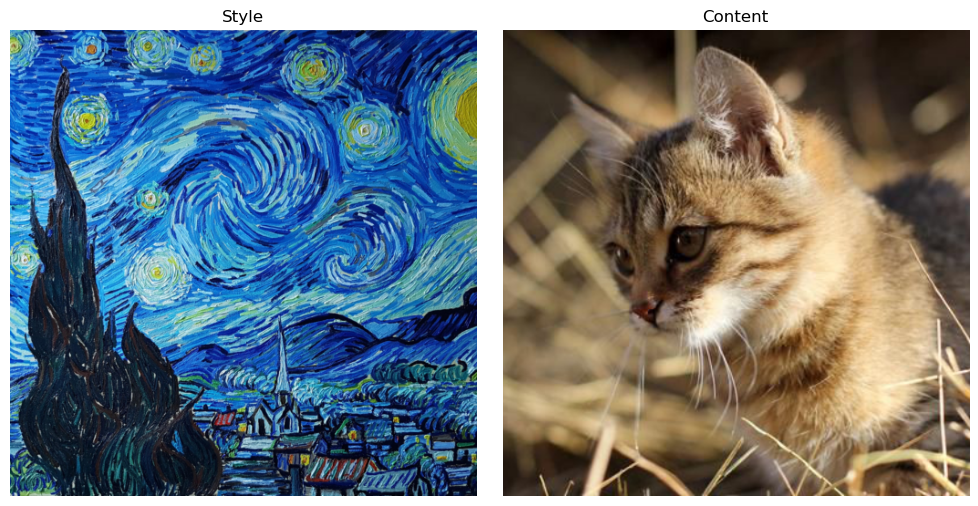

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

import copy

import requests
from PIL import Image
from io import BytesIO

from IPython.display import display

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

# URLs of the images (you can replace these with any image URLs)
content_image_url = "https://cataas.com/cat" #get a random cat
# content_image_url = 'https://i.natgeofe.com/n/fa48a59d-202e-4f47-9a22-6672c2b025d7/GettyImages-83454800-CROP_4x3.jpg'
style_image_url = "https://i.redd.it/832vtw88y4v11.jpg"
# style_image_url = "https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fwww.cubismartwork.com%2Fwp-content%2Fuploads%2F2023%2F09%2FJuan-Gris-cubism.jpg&f=1&nofb=1&ipt=c867df89fa59d2a79ba963f388e0b6c1eb8054fee2ae3d323b50d798c37a2c88"
#style_image_url = "https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fi.pinimg.com%2Foriginals%2Ff6%2Fa7%2F53%2Ff6a753589ffef6e1179f6ed85c8776dd.jpg&f=1&nofb=1&ipt=54fb7c681b305348ec4c1aef9eefbe1a2716e1e91eb4626a1bc652886781c3e6"

def get_image_from_url(url):
    response = requests.get(url)
    response.raise_for_status()
    return Image.open(BytesIO(response.content))

content_image = get_image_from_url(content_image_url)
style_image = get_image_from_url(style_image_url)

# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no GPU

# define a loader object that we can use to transform our image
loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.CenterCrop((imsize, imsize)),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor

# unsqueeze to have a batch dimension
content_tensor = loader(content_image).unsqueeze(0)
style_tensor   = loader(style_image).unsqueeze(0)

# define an unloader obj to get back our usual image
unloader = transforms.ToPILImage()

print(content_tensor.shape)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(unloader(style_tensor.cpu().clone().squeeze(0)))
plt.axis('off')
plt.title("Style")

plt.subplot(1, 2, 2)
plt.imshow(unloader(content_tensor.cpu().clone().squeeze(0)))
plt.axis('off')
plt.title("Content")

plt.tight_layout()
plt.show()

In [41]:
device

device(type='cuda')

## How the model work
### A shift of perspective
We need to train our image, yes our image. 

Our model will be standing still while the gradient is used to morph a copy of the content image to match the style.
But what defines quantitatively the content and the style of an image?

The main intuition of the paper above is that once we have a good model, the layers of the network have learned to recognize some fatures of the image we put into it.
Once we have our trained model we want to match the activations of the layers to align the morphed image to both match the style and the content.

For the content **activations should match one-to-one** so we want to minimize the norm of the difference between the activation of the content image and the morphed image

For the style **correlations between activations should match** so we want to minimize in some way the difference between the correlation matrix (or conversely the gram matrix) between activations given by the style image and the morphed image

---

Supponiamo di avere un modello con tanti layer

Img ref                 |

Img style               | LAYER 1 -> ... -> LAYER N

Img ref+style (output)  | 

Per ogni layer ci infilo la mia loss

d(ref, ref+style) = || ... ||_2; quanto diverse sono le attivazioni?

d(style, ref+style) = || corr(...) - corr(...)||_2 <- calcolo la matrice di correlazione

La rete è congelata!!! alleniamo SOLO l'immagine (vogliamo matchare lo stile)

---

The we can some all the contributes across the layers we select to compare.


In [42]:
# two losses 
# a loss is this case is an object that compares something that belongs 
# to the original image 
# to something that belongs to the target image


# we will insert those modules inside the model 
# so they will need to return their input unchanged
# loss value will be saved into the module
# later on we will get a handle to get all those losses

class ContentLoss(nn.Module):
    def __init__(self, content): # content è l'input dell'attivazione
        super(ContentLoss, self).__init__()
        # here save the reference content activation
        # pay attention that we do not want the gradient
        # to be propagated to the original image, how we can do it?
        
        self.content = content.clone().detach()
        # ATTENZIONE! mi interessa solo dei gradienti rilevanti (per cambiare l'immagine ref+style)


    def forward(self, x):
        self.loss = F.mse_loss(x, self.content) 
            # come faccio a introdurre la loss nel layer? uso qualcosa con pytorch
        # return unchanged the input
        return x 
        
def compute_gram_matrix(x):
    # ottengo misura della correlazione

    a, b, c, d = x.size()
    # a    -> batch size = 1 for our case
    # b, c -> height widht
    # d    -> channels

    features = x.view(a * b, c * d)  # resize

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):
    # same thing
    def __init__(self, style_feature):
        super(StyleLoss, self).__init__()

        self.style_feature = style_feature.clone().detach()

    def forward(self, x):
        self.loss = F.mse_loss(compute_gram_matrix(x), compute_gram_matrix(self.style_feature))

        return x


In [43]:
# get the model
cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

In [44]:
# normalize image values as done in vgg training
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

# create a module to normalize input image so we can easily put it in a
# ``nn.Sequential``
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = mean.view(-1, 1, 1)
        self.std = std.view(-1, 1, 1)

    def forward(self, img):
        # normalize ``img``
        return (img - self.mean) / self.std

In [45]:
# take a look inside our model
for name, layer in cnn.named_modules():
    print(f"Layer name: {name}, Layer type: {type(layer)}")

Layer name: , Layer type: <class 'torch.nn.modules.container.Sequential'>
Layer name: 0, Layer type: <class 'torch.nn.modules.conv.Conv2d'>
Layer name: 1, Layer type: <class 'torch.nn.modules.activation.ReLU'>
Layer name: 2, Layer type: <class 'torch.nn.modules.conv.Conv2d'>
Layer name: 3, Layer type: <class 'torch.nn.modules.activation.ReLU'>
Layer name: 4, Layer type: <class 'torch.nn.modules.pooling.MaxPool2d'>
Layer name: 5, Layer type: <class 'torch.nn.modules.conv.Conv2d'>
Layer name: 6, Layer type: <class 'torch.nn.modules.activation.ReLU'>
Layer name: 7, Layer type: <class 'torch.nn.modules.conv.Conv2d'>
Layer name: 8, Layer type: <class 'torch.nn.modules.activation.ReLU'>
Layer name: 9, Layer type: <class 'torch.nn.modules.pooling.MaxPool2d'>
Layer name: 10, Layer type: <class 'torch.nn.modules.conv.Conv2d'>
Layer name: 11, Layer type: <class 'torch.nn.modules.activation.ReLU'>
Layer name: 12, Layer type: <class 'torch.nn.modules.conv.Conv2d'>
Layer name: 13, Layer type: <clas

We need to perform some surgery on vgg and implant our new loss modules.
As specified above our modules should not interfere with the computation of the network and preserve the loss value inside them.

We then need to save a reference to them in a list to then be able to get access to the losses.


In [54]:
# desired depth layers to compute style/content losses :

# we want to insert our losses into the original model 
# obtain list of layers after which we want to insert our sort of losses
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5'] # scelgo; tutte dopo convolution ed evito maxpooling (non mi interessa)

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default, device = "cpu"):
    # normalization module

    cnn.to(device)
    normalization_mean.to(device)
    normalization_std.to(device)
    style_img.to(device)
    content_img.to(device)
    
    normalization = Normalization(normalization_mean, normalization_std)
    normalization.to(device)

    # just in order to have an iterable access to or list of content/style
    # losses
    content_losses = []
    style_losses = []

    # assuming that ``cnn`` is a ``nn.Sequential``, so we make a new ``nn.Sequential``
    # to put in modules that are supposed to be activated sequentially
    # create a new sequential that would be our new model 
    model = nn.Sequential(normalization)
    
    model.to(device)

    i = 0  # increment every time we see a conv; ne conto così so quando fermarmi
    j = 0
    k = 0
    # pass iterate inside the original cnn
    # the names we pass are conv_n where n is 
    # the position of the layer into the new
    for layer in cnn.children():

        # recognize in some way if we encountered a ConvLayer
        # if we find a conv layer count the depth at which we encountered it
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer,nn.ReLU):
            j += 1
            name = f'relu_{j}'
            layer = nn.ReLU(inplace=False)
        else:
            k += 1
            name = f'other_{k}'

        # add the current layer into the new model one
        model.add_module(name, layer)

        # if we meet one of our layers we want to add our losses
        if name in content_layers:
            # add content loss:
            # !!! remember that our loss object needs to be initialized with the correct activation
            # so you need to pass the content image through the model to obtain the reference value
            # to then construct our objects
            # perform a pass to construct the state of our loss
            activation = model(content_img)
            loss = ContentLoss(activation)
            model.add_module(f'content_loss_{len(content_losses)}', loss)
            # keep the reference of our loss in an array
            content_losses.append(loss)

        if name in style_layers:
            # add style loss:
            # perform a pass to construct the state of our loss
            activation = model(style_img)
            loss = StyleLoss(activation)
            model.add_module(f'content_loss_{len(style_losses)}', loss)
            # keep the reference of our loss in an array
            style_losses.append(loss)

    # now we trim off the layers after the last content and style losses
    # we do not need to keep all the layers after the last one we inserted
    # one of our losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In the optimization loop we need to optimize the image not the model.
The authors suggest LBFGS as optimizer (very precise but very very expensive, this is why it is not used in ml).
The optimizer will take as input in the construction the image we want to optimize.

To use bfgs in torch we need to define a closure so a function that closes over the context and makes the loss computation go ahead.
In the closure we want to perform our forward pass and then to call backward.

Our losses are available to the references in the lists we fot from `get_style_model_and_losses`

In [55]:
# we need to transform to tensor and then
# to add a fake batch dimension in the first one
import tqdm as tqdm

def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, device = "cpu", num_steps=300,
                       style_weight=1000000, content_weight=1, freq = 50):
    """Run the style transfer."""

    # copy everything on the device
    content_img = content_img.to(device)
    style_img = style_img.to(device)
    input_img = input_img.to(device)
    normalization_mean = normalization_mean.to(device)
    normalization_std = normalization_std.to(device)
    
    print('Building the style transfer model..')
    # build the model
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img, device = device)

    model = model.to(device)
    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    # We also put the model in evaluation mode, so that specific layers
    # such as dropout or batch normalization layers behave correctly.
    model.eval()
    model.requires_grad_(False)

    # use lbfgs to optimize (you can maybe, maybe try also adam)
    # I doubt with SGD you will get something usefull
    optimizer = optim.LBFGS([input_img])

    losses = []
    images = []
    last_loss = [0, 0]
    print('Optimizing...')
    log_output = [True]
    for r in range(num_steps):

        # a trick to pass int to mutate into a closure
        # remeber that by default mutable obj are passed by reference
        # immmutable obj are passed by value (by default int, floats etc are immutable)
        log_output[0] = True 
        # a trick to make lbfgs work (passaggio per referenza)
        def closure(): # specie di lambda function
            # clamp the image to prevent quirky things 
            with torch.no_grad():
                input_img.clamp_(0, 1)

            # usual training loop
            # the difference is now that we want to iterate on losses
            # to gather the values saved into a single loss tensor
            # that we can use to backward into our image
    
            optimizer.zero_grad()
            # fp
            model(input_img)

            # bp; voglio ottenere i gradienti
            style_score = torch.tensor(0.)
            content_score = torch.tensor(0.)

            for c_loss in content_losses:
                content_score += c_loss.loss * content_weight        

            for s_loss in style_losses:
                style_score += s_loss.loss * style_weight

            global_loss = style_score + content_score
            global_loss.backward()    
            
            if r % freq == 0 and log_output[0]:
                # log ogni freq
                print(f"run {r}:")
                print(f"Style Loss : {style_score.item():4f} Content Loss: {content_score.item():4f}")
                print()
                log_output[0] = False
                images.append(input_img.clone().detach().clamp_(0,1))
                losses.append((content_score.item(), style_score.item()))
                
            return style_score + content_score

        
        optimizer.step(closure)


    # a last correction...
    with torch.no_grad():
        images.append(input_img.clone().detach().clamp_(0,1))
        losses.append(last_loss[0])

    return images, losses

In [56]:
input_tensor   = content_tensor.clone()
output, losses = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_tensor, style_tensor, input_tensor, device, num_steps = 50, style_weight = 100000, freq = 5)

Building the style transfer model..


RuntimeError: The size of tensor a (512) must match the size of tensor b (256) at non-singleton dimension 3

In [38]:
def show_images(images, losses, cols=5, figsize=(17, 10)):
    rows = (len(images) + cols - 1) // cols
    plt.figure(figsize=figsize)
    for i, img in enumerate(images):
        plt.subplot(rows, cols, i + 1)
        plt.title(f"content loss {losses[i][0]: .1f}, style loss {losses[i][1]: .1f}", fontsize = 12)
        plt.imshow(img.squeeze().cpu().permute(1, 2, 0).numpy())
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_images(output, losses)

NameError: name 'output' is not defined